## Importing libraries

In [ ]:
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

## import modules for NLP
import nltk
from nltk.corpus import stopwords

## import the modules for train & test data
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

## word2vec with gensim; press pip install -U gensim before importing
import gensim

## Loading the data and adding two additional features Text length and Number of words

In [ ]:
train_df = pd.read_csv('train.csv', usecols = ["text", "target"])
test_df = pd.read_csv('test.csv', usecols = ["id", "text"])

print("col_names : " + train_df.columns)
print('\n')
print("Data-dimensions:" + '\t' + str(train_df.shape))
print('\n')
print("Count the not-null values of each features: \n" + str(train_df.notnull().sum()))

train_df.drop_duplicates(inplace = True)
print("The new dimension after checking duplicate & removing is:\t" + str(train_df.shape))

train_df['Text_length'] = train_df['text'].str.len()
train_df['Numb_words'] = train_df['text'].str.split().map(lambda x: len(x))

test_df['Text_length'] = test_df['text'].str.len()
test_df['Numb_words'] = test_df['text'].str.split().map(lambda x: len(x))
train_df.head()

Index(['col_names : text', 'col_names : target'], dtype='object')


Data-dimensions:	(7613, 2)


Count the not-null values of each features: 
text      7613
target    7613
dtype: int64
The new dimension after checking duplicate & removing is:	(7521, 2)


,text,target,Text_length,Numb_words
0,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,Forest fire near La Ronge Sask. Canada,1,38,7
2,All residents asked to 'shelter in place' are ...,1,133,22
3,"13,000 people receive #wildfires evacuation or...",1,65,8
4,Just got sent this photo from Ruby #Alaska as ...,1,88,16


In [ ]:
test_df.head()

,id,text,Text_length,Numb_words
0,0,Just happened a terrible car crash,34,6
1,2,"Heard about #earthquake is different cities, s...",64,9
2,3,"there is a forest fire at spot pond, geese are...",96,19
3,9,Apocalypse lighting. #Spokane #wildfires,40,4
4,11,Typhoon Soudelor kills 28 in China and Taiwan,45,8


## Preprocessing the data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.text import one_hot


Using TensorFlow backend.


In [ ]:
y = train_df.target.to_numpy()
X = train_df[['text', 'Text_length']]

In [ ]:
# Word2vec model for embeddings  
from gensim.models import Word2Vec
# For extracting pre-trained vectors  
from gensim.models import KeyedVectors
# PCA for dimensionality reduction
from sklearn.decomposition import PCA

import re  # For preprocessing
#import spacy  # For preprocessing

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

sentences = train_df['text']

from tqdm import tqdm


from nltk.tokenize import word_tokenize

stop = set(stopwords.words('english'))

def create_corpus(data):
    corpus=[]
    for tweet in tqdm(data['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus=create_corpus(train_df)

100%|██████████| 7521/7521 [00:01<00:00, 5136.89it/s]


In [ ]:
MAX_LEN = 32
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 15015


In [ ]:
embedding_dict={}
with open('glove.6B.100d.txt', 'r', encoding='utf8', errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, 100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 15015/15015 [00:00<00:00, 546812.37it/s]


In [ ]:
X_train, X_test,y_train,y_test = train_test_split(tweet_pad, y, test_size = 0.25)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (5640, 32)
Shape of Validation  (1881, 32)


## Building and training the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D

model=Sequential()

embedding=Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.1))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           1501600   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 32, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,543,905
Trainable params: 42,305
Non-trainable params: 1,501,600
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 20, validation_data = (X_test, y_test), verbose=2)

Train on 5640 samples, validate on 1881 samples
Epoch 1/20
 - 2s - loss: 0.6034 - accuracy: 0.6730 - val_loss: 0.4866 - val_accuracy: 0.7911
Epoch 2/20
 - 1s - loss: 0.4881 - accuracy: 0.7830 - val_loss: 0.4491 - val_accuracy: 0.8022
Epoch 3/20
 - 1s - loss: 0.4715 - accuracy: 0.7945 - val_loss: 0.4435 - val_accuracy: 0.8070
Epoch 4/20
 - 1s - loss: 0.4600 - accuracy: 0.7943 - val_loss: 0.4431 - val_accuracy: 0.7990
Epoch 5/20
 - 1s - loss: 0.4480 - accuracy: 0.8007 - val_loss: 0.4379 - val_accuracy: 0.8060
Epoch 6/20
 - 1s - loss: 0.4448 - accuracy: 0.8090 - val_loss: 0.4309 - val_accuracy: 0.8049
Epoch 7/20
 - 1s - loss: 0.4447 - accuracy: 0.8053 - val_loss: 0.4305 - val_accuracy: 0.8081
Epoch 8/20
 - 1s - loss: 0.4326 - accuracy: 0.8073 - val_loss: 0.4330 - val_accuracy: 0.8017
Epoch 9/20
 - 1s - loss: 0.4241 - accuracy: 0.8160 - val_loss: 0.4376 - val_accuracy: 0.8054
Epoch 10/20
 - 1s - loss: 0.4242 - accuracy: 0.8140 - val_loss: 0.4278 - val_accuracy: 0.8075
Epoch 11/20
 - 1s - l

## Evaluating the model

In [ ]:
score, tr_acc = model.evaluate(X_train, y_train)
score, t_acc = model.evaluate(X_test, y_test)

print('Train accuracy:', tr_acc)
print('Test accuracy:', t_acc)

1881/1881 [==============================] - 0s 153us/step
Train accuracy: 0.8666666746139526
Test accuracy: 0.8107389807701111


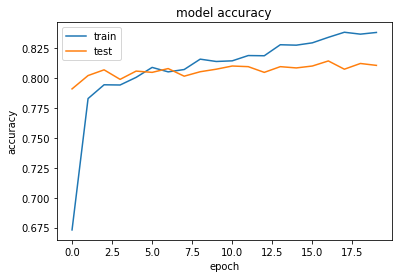

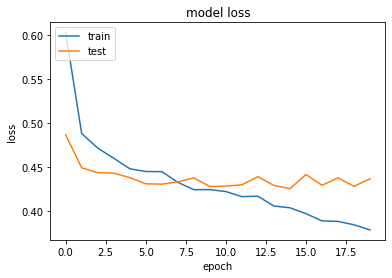

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()